<a href="https://colab.research.google.com/github/alayacruz/CynapticsInductions/blob/main/Copy_of_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pdb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
%matplotlib inline

In [2]:
def show(tensor,ch=1, size=(28,28), num=16): #channel=1(for grayscale), num- number of images in grid
  data=tensor.detach().cpu().view(-1,ch,*size) #detach().cpu()- stores tensor in cpu from computation graph; view(--)= reshapes the tensor
  grid=make_grid(data[:num],nrow=4).permute(1,2,0) #Rearranges the dimensions of the grid for visualization (from [C, H, W] to [H, W, C]).

  plt.imshow(grid)
  plt.show()



In [3]:
epoch=500
cur_iter=0 #counter keep track of current iteration
info_iter=300 #interval between log progress
mean_gen_loss=0
mean_disc_loss=0

z_dim=64
lr=0.0001 #learning rate for optimizer
loss=nn.BCEWithLogitsLoss() #binary cross entropy with logits ,for binary classification tasks like the discriminators real vs fake thing
batch_size=128
device="cuda"


In [4]:
dataloader=DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),batch_size=batch_size,shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]


In [5]:
def genBlock(inp_nodes,out_nodes): #inp_nodes are the input features ie the size of vector that the linear layer can expect; and out_nodes is the size of output vector produced by the linear layer
    return nn.Sequential(
        nn.Linear(inp_nodes,out_nodes), #fully connected linear layer, applies linear transformation, y=xW
        nn.BatchNorm1d(out_nodes), #normalizes the output from the previous layer
        nn.ReLU() #rectified linear unit
    )

In [6]:
def gen_noise(batch_size,z_dim): #function to generate noise to be supplied to the generator
    return torch.randn(batch_size,z_dim).to(device)
    #torch.randn generates a tensor of size(batch_size,z_dim); .todevice() moves the generated tensor to the device

In [7]:
class Generator(nn.Module): #inherited from parent class module
  def __init__(self,z_dim=64,o_dim=784,h_dim=128):
    super().__init__() #calling constructor of parent

    self.gen=nn.Sequential(
        genBlock(z_dim,h_dim),
        genBlock(h_dim,h_dim*2),
        genBlock(h_dim*2,h_dim*4), #by increasing the dimensionality with each call we are increasing the complexity and enabling it to capture finer details.
        genBlock(h_dim*4,h_dim*8), #cant increase it directly thats why step by step
        nn.Linear(h_dim*8,o_dim),
        nn.Sigmoid(),

    )
  def forward(self,noise):
      return self.gen(noise)


In [8]:
def discblock(inp_nodes,out_nodes):
    return nn.Sequential( #nn.sequential is a container layer which allows you to stack layers together
        nn.Linear(inp_nodes,out_nodes),
        nn.LeakyReLU(0.2), #unlike standard relu leaky relu allows a small negative gradient 0.2 in this case
        nn.Dropout(0.2) #randomnly drops out a fraction of the neurons in a layer ie they dont contribute to forward or backward
    )


In [9]:
class Discriminator(nn.Module):
  def __init__(self,inp_dim=784,hidden_dim=128):
    super().__init__()

    self.disc=nn.Sequential(
        discblock(inp_dim,hidden_dim*5),
        discblock(hidden_dim*5,hidden_dim*3),
        discblock(hidden_dim*3,hidden_dim),
        nn.Linear(hidden_dim,1),

    )
  def forward(self,image):
     return self.disc(image)


In [10]:
gen=Generator(z_dim).to(device) #instance of generator class
gen_opt=torch.optim.RMSprop(gen.parameters(),lr=0.0002) #optimizer to update parameters after backforwarding, adam algorithim of optimization is used
disc=Discriminator().to(device)
disc_opt=torch.optim.RMSprop(disc.parameters(),lr=lr)

In [11]:
def gen_loss(loss_func,gen,disc,batch_size,z_dim):
  noise=gen_noise(batch_size,z_dim)
  fake=gen(noise)
  pred=disc(fake) #1=real; 0=fake
  target=torch.ones_like(pred) #creates a tensor of ones with the same size as pred. these are target labels for the gen which aims to make the discriminator believe that all images are real
  return loss_func(pred,target)

In [12]:
def disc_loss(loss_func,disc,gen,batch_size,z_dim,real):
  noise=gen_noise(batch_size,z_dim)
  fake=gen(noise)
  disc_fake=disc(fake.detach())
  disc_fake_target=torch.zeros_like(disc_fake)+0.1
  disc_fake_loss=loss_func(disc_fake,disc_fake_target)

  disc_real=disc(real)
  disc_real_target=torch.ones_like(disc_real)-0.1
  disc_real_loss=loss_func(disc_real,disc_real_target)

  return(disc_fake_loss+disc_real_loss)/2


works


  0%|          | 0/469 [00:00<?, ?it/s]

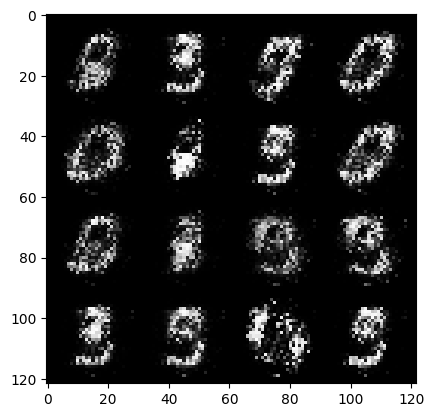

0 : step 300, Generator loss : 1.08949509203434, Discriminator Loss : 0.5677749166886012
works


  0%|          | 0/469 [00:00<?, ?it/s]

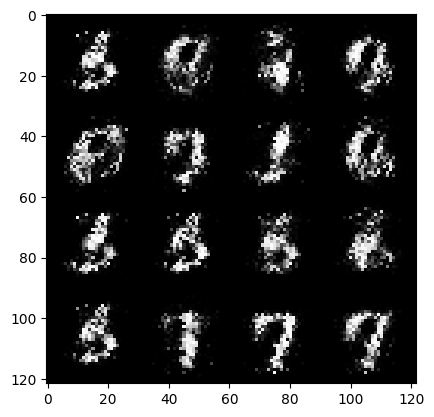

1 : step 600, Generator loss : 1.16806490679582, Discriminator Loss : 0.5754496216773989


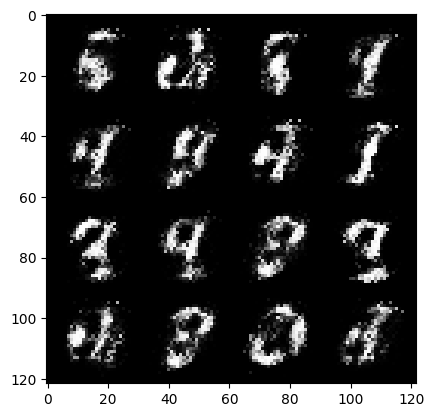

1 : step 900, Generator loss : 1.1428353154659272, Discriminator Loss : 0.5846775639057161
works


  0%|          | 0/469 [00:00<?, ?it/s]

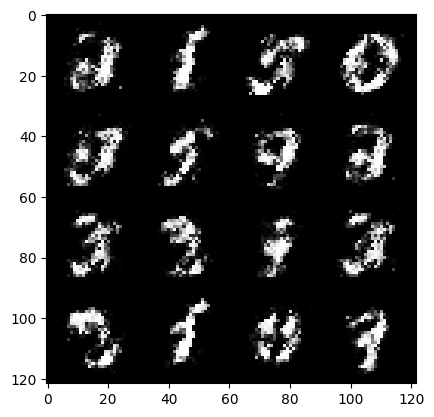

2 : step 1200, Generator loss : 1.111896957159043, Discriminator Loss : 0.5959601797660192
works


  0%|          | 0/469 [00:00<?, ?it/s]

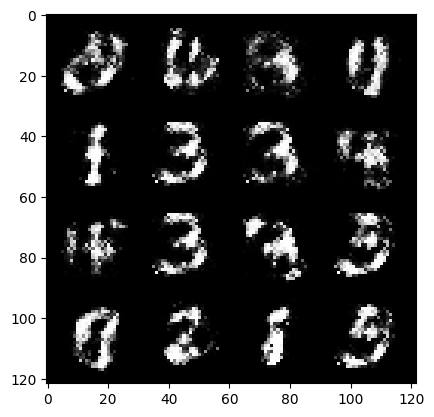

3 : step 1500, Generator loss : 1.1019660089413317, Discriminator Loss : 0.6012865654627485


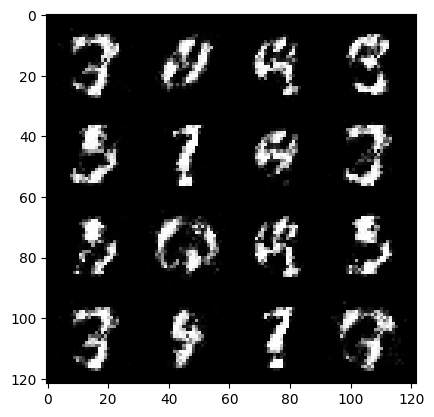

3 : step 1800, Generator loss : 1.065258265733718, Discriminator Loss : 0.6073848424355187
works


  0%|          | 0/469 [00:00<?, ?it/s]

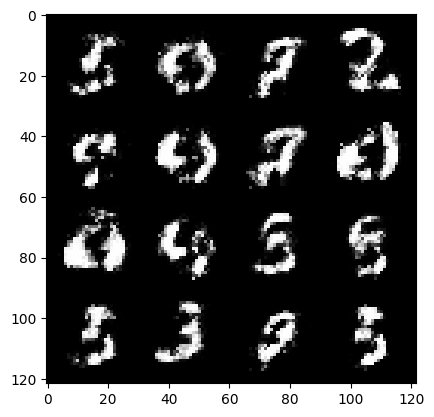

4 : step 2100, Generator loss : 1.0257728868722922, Discriminator Loss : 0.6150324386358264
works


  0%|          | 0/469 [00:00<?, ?it/s]

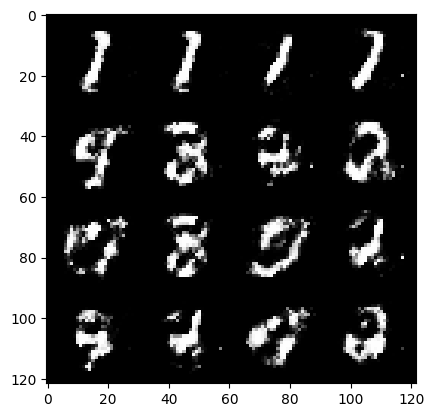

5 : step 2400, Generator loss : 1.0114639451106386, Discriminator Loss : 0.6211118598779041


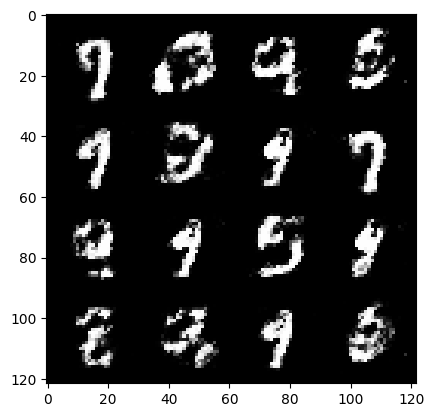

5 : step 2700, Generator loss : 0.9876651990413667, Discriminator Loss : 0.6258866719404856
works


  0%|          | 0/469 [00:00<?, ?it/s]

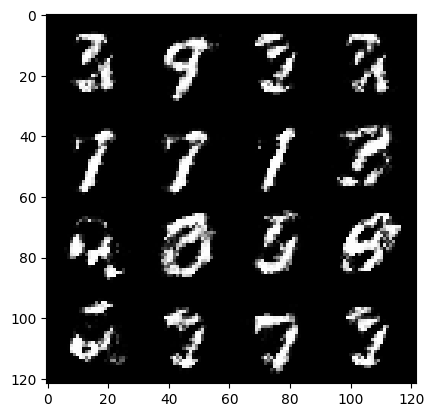

6 : step 3000, Generator loss : 0.9888676931460704, Discriminator Loss : 0.6214520816008247
works


  0%|          | 0/469 [00:00<?, ?it/s]

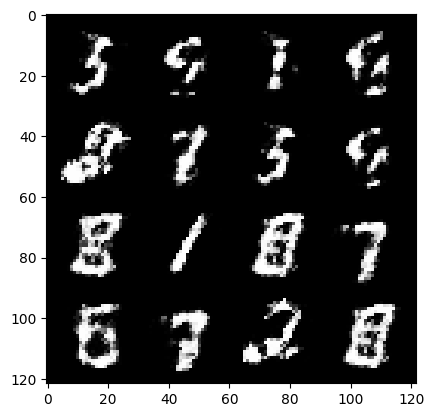

7 : step 3300, Generator loss : 0.982244277199109, Discriminator Loss : 0.6259927036364871


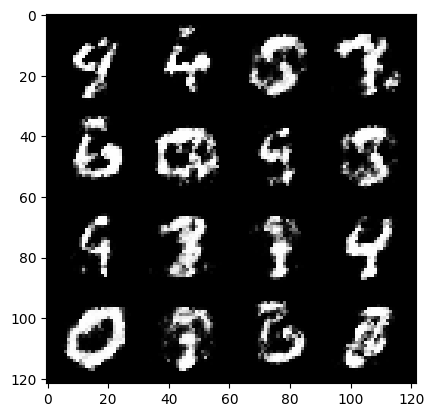

7 : step 3600, Generator loss : 0.9947951930761342, Discriminator Loss : 0.6218246430158615
works


  0%|          | 0/469 [00:00<?, ?it/s]

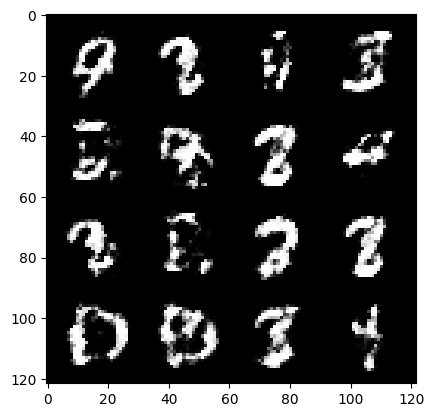

8 : step 3900, Generator loss : 0.9600958599646883, Discriminator Loss : 0.6318922700484592


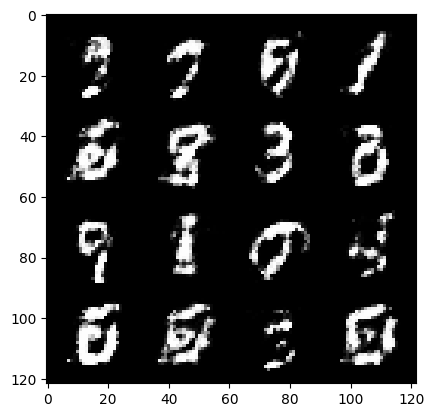

8 : step 4200, Generator loss : 0.963661703864734, Discriminator Loss : 0.6302299930651986
works


  0%|          | 0/469 [00:00<?, ?it/s]

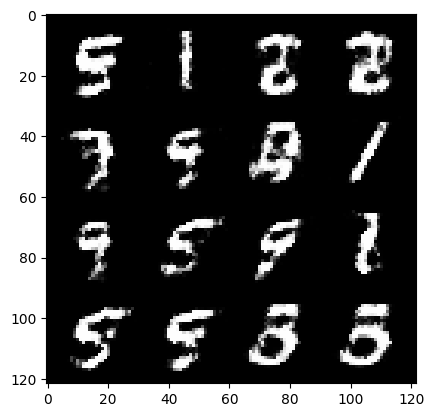

9 : step 4500, Generator loss : 0.9377229958772667, Discriminator Loss : 0.6350580257177357
works


  0%|          | 0/469 [00:00<?, ?it/s]

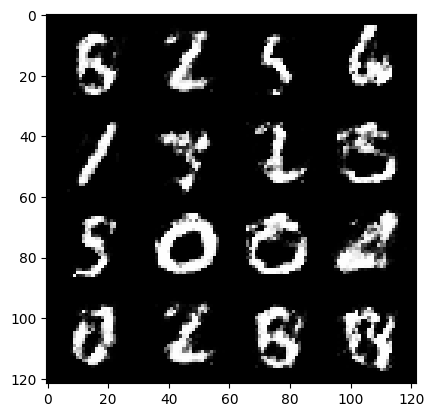

10 : step 4800, Generator loss : 0.9238845670223231, Discriminator Loss : 0.639276979764303


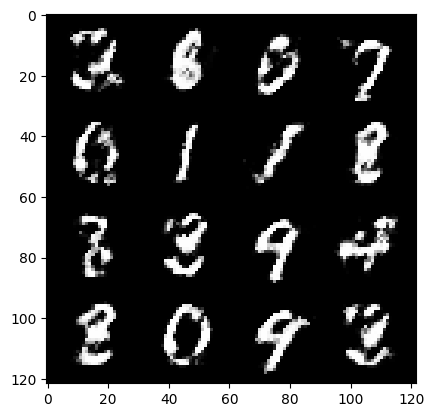

10 : step 5100, Generator loss : 0.9080794801314673, Discriminator Loss : 0.6421867634852724
works


  0%|          | 0/469 [00:00<?, ?it/s]

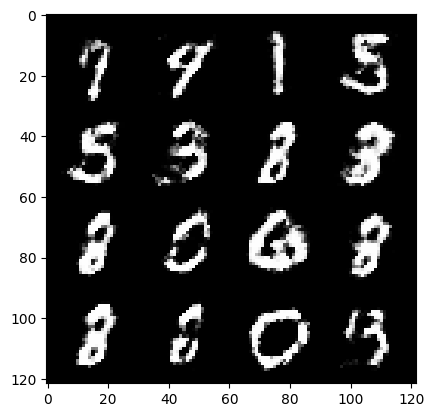

11 : step 5400, Generator loss : 0.903745643099149, Discriminator Loss : 0.6454887054363895
works


  0%|          | 0/469 [00:00<?, ?it/s]

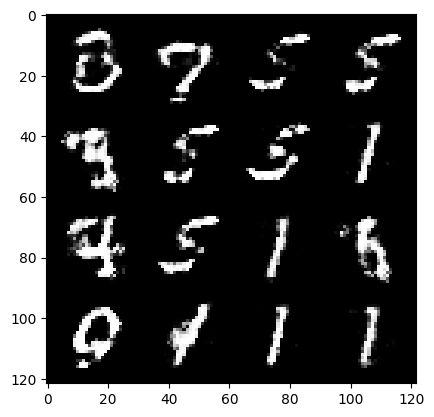

12 : step 5700, Generator loss : 0.9035272409518563, Discriminator Loss : 0.6411248097817104


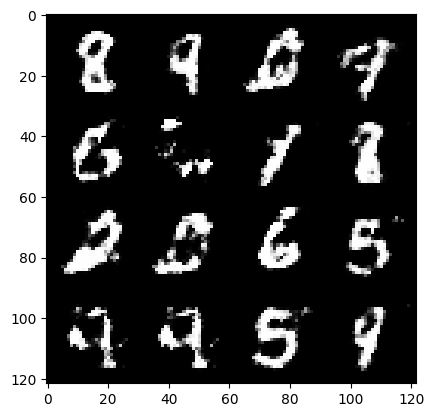

12 : step 6000, Generator loss : 0.9120171936353055, Discriminator Loss : 0.6407944055398306
works


  0%|          | 0/469 [00:00<?, ?it/s]

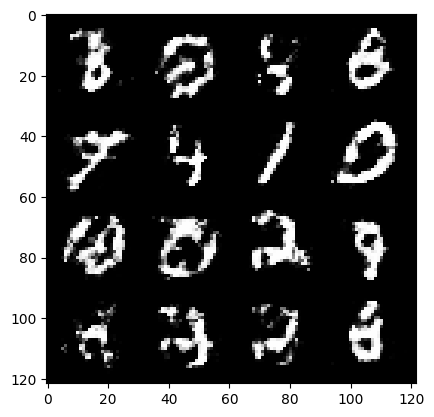

13 : step 6300, Generator loss : 0.8968173589309056, Discriminator Loss : 0.6452225732803342
works


  0%|          | 0/469 [00:00<?, ?it/s]

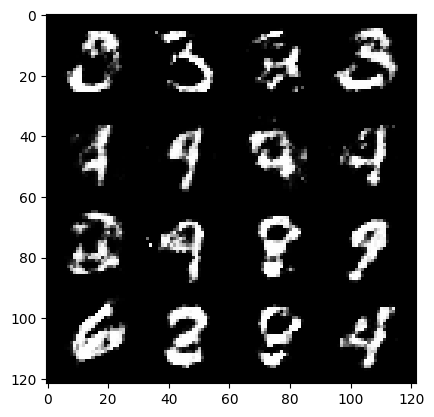

14 : step 6600, Generator loss : 0.8936462328831358, Discriminator Loss : 0.6441164376338322


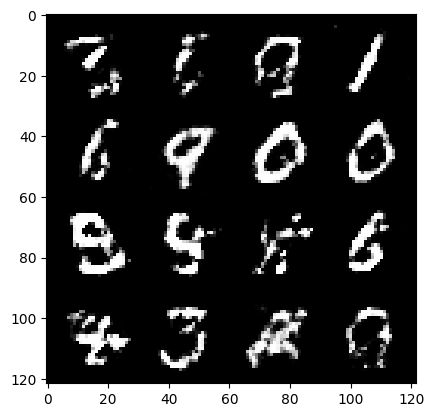

14 : step 6900, Generator loss : 0.8891301886240637, Discriminator Loss : 0.6447647565603252
works


  0%|          | 0/469 [00:00<?, ?it/s]

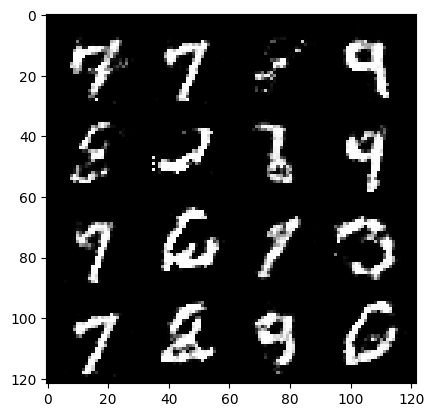

15 : step 7200, Generator loss : 0.8953451035420104, Discriminator Loss : 0.6427463777860002


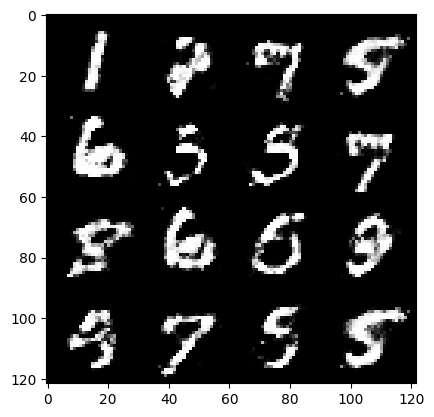

15 : step 7500, Generator loss : 0.8961952630678814, Discriminator Loss : 0.6416366191705074
works


  0%|          | 0/469 [00:00<?, ?it/s]

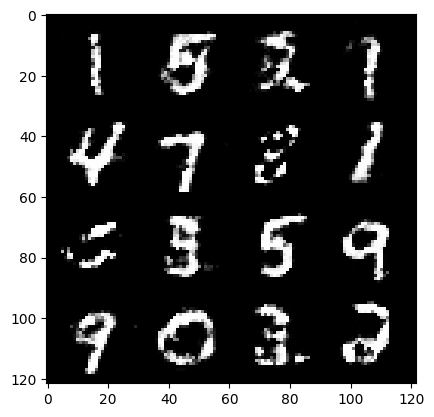

16 : step 7800, Generator loss : 0.904794393777847, Discriminator Loss : 0.6402260075012843
works


  0%|          | 0/469 [00:00<?, ?it/s]

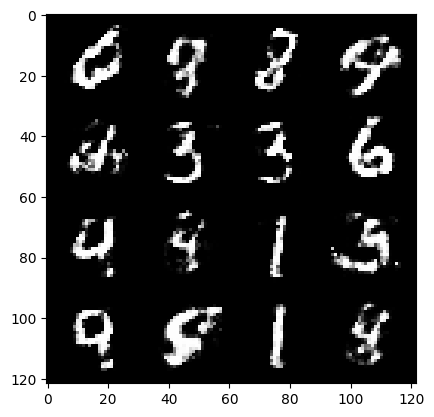

17 : step 8100, Generator loss : 0.9063712447881701, Discriminator Loss : 0.640060207049052


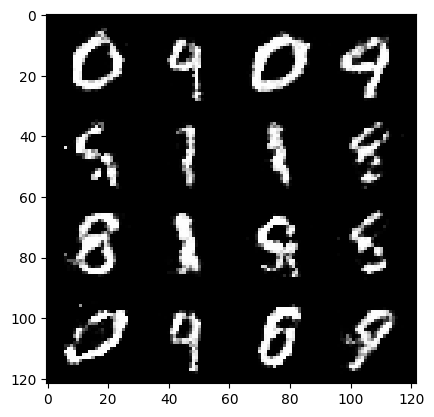

17 : step 8400, Generator loss : 0.9045830305417372, Discriminator Loss : 0.6392243967453639
works


  0%|          | 0/469 [00:00<?, ?it/s]

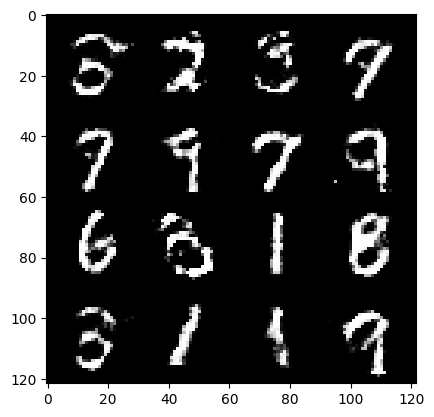

18 : step 8700, Generator loss : 0.912358066042264, Discriminator Loss : 0.636776733994484


KeyboardInterrupt: 

In [13]:
for epoch in range(epoch):
  print('works')
  mean_disc_loss_list=[]
  mean_gen_loss_list=[] #resetting the lists for each epoch
  iters_list=[]

  for real_image, _ in tqdm(dataloader): #tqdm bar provides a progress bar to check the progress
    disc_opt.zero_grad() #before backprpopogation the gradients are zeroed out
    cur_batch_size=len(real_image)
    real_image=real_image.view(cur_batch_size,-1).to(device ) #the real image tensor is reshaped to 2d and moved to specified device
    disc_losses=disc_loss(loss,disc,gen,cur_batch_size,z_dim,real_image)
    disc_losses.backward() #backward propogation
    disc_opt.step() #step is called to update the discriminators weights

    gen_opt.zero_grad()
    gen_losses=gen_loss(loss,gen,disc,cur_batch_size,z_dim)
    gen_losses.backward() #backpropogation is used to compute the gradients of the loss function. finally gradient descent is used to update the parameters to minimize the loss func
    gen_opt.step()

    mean_disc_loss += disc_losses.item()/info_iter
    mean_gen_loss += gen_losses.item()/info_iter
    mean_disc_loss_list.append(mean_disc_loss)
    mean_gen_loss_list.append(mean_gen_loss)


    if(cur_iter%info_iter==0 and cur_iter>0): #this block of code runs at every multiple of info_iter and not on the first iter
      fake_noise=gen_noise(batch_size,z_dim)
      fake=gen(fake_noise)
      #show(real_image)
      show(fake)
      print(f"{epoch} : step {cur_iter}, Generator loss : {mean_gen_loss}, Discriminator Loss : {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0, 0

    iters_list.append(cur_iter)
    cur_iter+=1

